In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [30]:
dtype = {
    'rate-reason-deletions': 'Int64',
    'rate-RAT-introductions': 'Int64',
    'rate-RUP-introductions': 'Int64',
}
checkers = 'rate', 'rate-d', 'drat-trim', 'gratgen'
df = pd.read_csv('results.csv', dtype=dtype)

df['time-delta-rate-rate-d'] = df['rate-time'] - df['rate-d-time']
df['time-delta-percent-rate-rate-d'] = (df['rate-time'] - df['rate-d-time']) / df['rate-time']
df['space-delta-rate-rate-d'] = df['rate-space'] - df['rate-d-space']
df['space-delta-percent-rate-rate-d'] = (df['rate-space'] - df['rate-d-space']) / df['rate-space']
df['rate-reason-deletions-not-shrinking-trail'] = (df['rate-reason-deletions'] -
   df['rate-reason-deletions-shrinking-trail'])

verified = 'verified'
verified = 'lrat-check pending' # not run again

df['space-delta-rate-drat-trim'] = df['rate-space'] - df['drat-trim-space']

vf = df[
    # (df['rate-result'] == 'NOT VERIFIED')
    # |
    # (df['rate-result'] == 'error')
    (df['rate-solution'].notnull()) # ran with rate
    & (df['rate-solution'] != 'NOT VERIFIED') # not rejected
    & (df['rate-result'] != 'error') # not errored cuz invalid proof
    & (df['rate-d-result'] == verified)
    & (df['drat-trim-result'] == verified)
    & (df['gratgen-result'] == 'verified')
]

In [29]:
set(df['rate-solution'])
set(df['rate-result'])

{'error',
 'lrat-check pending',
 nan,
 'out of memory',
 'out of time',
 'rejected'}

In [25]:
#vf[vf['rate-time'] > 17500]
#vf[vf['rate-d-time'] > 17500]
# vf[vf['drat-trim-time'] > 17500]
# vf[vf['gratgen-time'] > 17500]['gratgen-time']


In [26]:
#set(vf['drat-trim-result'])
#set(vf['gratgen-result'])

In [27]:
#set(df['rate-result'])

In [24]:
for i, a in df[df['rate-solution'] == 'error'].iterrows():
    print(a['instance'], a['solver'], a['rate-result'])

mchess_17 abcdsat_r18@default out of time
pals_lcr.8_overflow_false-unreach-call.ufo.UNBOUNDED.pals.c smallsat@default out of time
pals_lcr-var-start-time.6_true-unreach-call.ufo.UNBOUNDED.pals.c GHackCOMSPS_drup@ghack_drup out of memory
T92.2.0 CaDiCaL@DONTUNZIP-fixed error


In [123]:
checkers = 'rate', 'rate-d', 'drat-trim', 'gratgen'
LABELS = {
    'space': 'memory usage (MB)',
    'time': 'runtime (s)',
    'rate-reason-deletions': 'reason deletions',
    'rate-reason-deletions-shrinking-trail': 'non-redundant reason deletions',
    'rate-reason-deletions-not-shrinking-trail': 'redundant reason deletions',
}
COLORS = {
    'rate': 'red',
    'rate-d': 'orange',
    'drat-trim': 'darkcyan',
    'gratgen': 'blue',
}
MARKERS = {
    'rate': '1',
    'rate-d': '2',
    'drat-trim': '3',
    'gratgen': '4',
}

for c1 in checkers:
    # LABELS[f'{c1}-time'] = f'{c1} runtime (s)'
    # LABELS[f'{c1}-space'] = f'{c1} memory usage (MB)'
    LABELS[f'{c1}-time'] = ''
    LABELS[f'{c1}-space'] = ''
    for c2 in checkers:
        # LABELS[f'time-delta-{c1}-{c2}'] = f'runtime overhead of {c1} compared to {c2}'
        # LABELS[f'time-delta-percent-{c1}-{c2}'] = f'runtime overhead of {c1} compared to {c2}'
        # LABELS[f'space-delta-{c1}-{c2}'] = f'memory usage overhead of {c1} compared to {c2}'
        # LABELS[f'space-delta-percent-{c1}-{c2}'] = f'memory usage overhead of {c1} compared to {c2}'
        LABELS[f'time-delta-percent-{c1}-{c2}'] = f'runtime'
        LABELS[f'space-delta-percent-{c1}-{c2}'] = f'memory usage'

def sort_by_col(df, col):
    tmp = df.sort_values(col)
    tmp['index'] = np.arange(len(tmp))
    return tmp

def set_labels(ax, x=None, y=None):
    if x is not None:
        ax.set_xlabel(LABELS[x])
    if y is not None:
        ax.set_ylabel(LABELS[y])

def boxplot(df, y, cs=checkers, **kwargs):
    ax = df[[f'{checker}-{y}' for checker in checkers]].boxplot()
    set_labels(ax, y=y)

def compare(ax, df, y, cs=checkers, **kwargs):
    x = list(range(len(df)))
    for checker in cs:
        sort_by_col(df, f'{checker}-{y}').plot(x='index', y=f'{checker}-{y}', ax=ax, \
                                               kind='scatter', marker=MARKERS[checker],
                                               color=COLORS[checker], label=checker, **kwargs)
    ax.legend(loc='upper left')
    plt.xlabel('proofs verified by all checkers')
    set_labels(ax, y=y)

def crossplot(df, x, y):
    limit = max(df[x].max(), df[y].max()) * 1.02
    ax = df.plot(x, y, kind='scatter', marker='1', xlim=(0, limit), ylim=(0, limit))
    ax.plot((0, limit), (0, limit), color='green', linestyle='dashed', linewidth=1)
    set_labels(ax, x, y)

def correlation(ax, df, x, y, percent=False, **kwargs):
    vf.plot(x, y, ax=ax, kind='scatter', marker='3', **kwargs);
    limit = df[x].max()
    ax.plot((0, limit), (0, 0), color='green', linestyle='dashed', linewidth=1)
    if percent:
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y:.0%}'.replace('%', r'\%')))
    set_labels(ax, x, y)

SAVE_FIGURES = 1
def persist(name, needPDF=True, needSVG=False, needPNG=False):
    if SAVE_FIGURES:
        if needPDF: plt.savefig(f'p/{name}.pdf')
        if needSVG: plt.savefig(f'p/{name}.svg')
        if needPNG: plt.savefig(f'p/{name}.png')

In [124]:
vf[[f'{checker}-time' for checker in checkers]].describe()

,rate-time,rate-d-time,drat-trim-time,gratgen-time
count,810.000000,810.000000,810.000000,810.000000
mean,1379.300222,1319.767926,1626.197321,1117.911790
std,1979.374855,1882.517768,2466.341800,1703.778599
min,0.460000,0.410000,0.450000,0.310000
25%,215.750000,207.747500,204.145000,130.792500
50%,676.875000,664.075000,763.315000,550.315000
75%,1752.297500,1588.492500,1763.387500,1209.812500
max,16552.510000,14813.800000,15773.410000,11609.950000


In [125]:
# outliers = []
# # rate-d high time
# outliers += [vf['rate-d-time'].idxmax()]

In [126]:
# # high memory usage
# outliers += [vf['rate-space'].idxmax()]

In [127]:
# # many reason deletions
# outliers += [vf['rate-reason-deletions'].map(int).idxmax()]

In [128]:
# outliers += [vf['space-delta-rate-rate-d'].idxmax()]

In [129]:
# for outlier in outliers:
#     row = vf.loc[outlier]
#     print(f'{row.instance}/{row.solver}')

In [130]:
vf.columns

Index(['instance', 'solver', 'stime', 'sresult', 'rate-result', 'rate-time',
       'rate-space', 'rate-solution', 'rate-verified', 'rate-reason-deletions',
       'rate-reason-deletions-shrinking-trail', 'rate-RAT-introductions',
       'rate-RUP-introductions', 'rate-d-result', 'rate-d-time',
       'rate-d-space', 'rate-d-solution', 'rate-d-verified',
       'rate-d-reason-deletions', 'gratgen-result', 'gratgen-time',
       'gratgen-space', 'gratgen-solution', 'gratgen-verified',
       'drat-trim-result', 'drat-trim-time', 'drat-trim-space',
       'drat-trim-solution', 'drat-trim-verified', 'time-delta-rate-rate-d',
       'time-delta-percent-rate-rate-d', 'space-delta-rate-rate-d',
       'space-delta-percent-rate-rate-d',
       'rate-reason-deletions-not-shrinking-trail',
       'space-delta-rate-drat-trim'],
      dtype='object')

In [131]:
easy_problems = 700

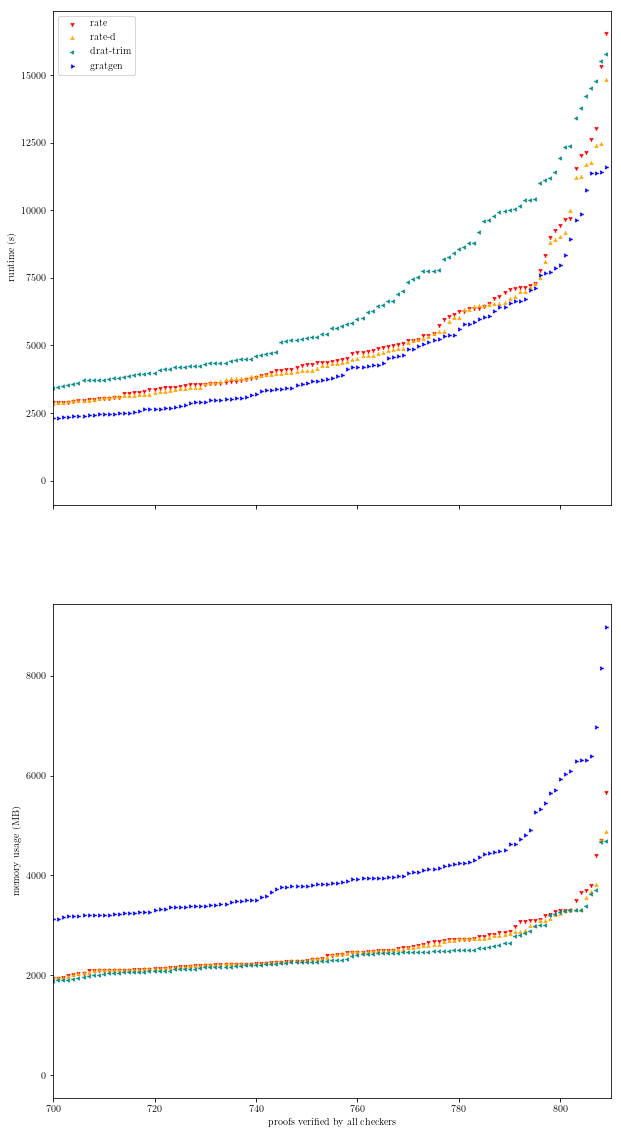

In [227]:
def mcompare(ax, df, y, cs=checkers, **kwargs):
    x = list(range(len(df)))
    for checker in cs:
        sort_by_col(df, f'{checker}-{y}').plot(x='index', y=f'{checker}-{y}', ax=ax, \
                                               kind='scatter', marker=MARKERS[checker],
                                               color=COLORS[checker], label=checker, **kwargs)
        ax.legend(loc='upper left')
        plt.xlabel('proofs verified by all checkers')
        set_labels(ax, y=y)

fig, axes = plt.subplots(2, 1, sharex='all', figsize=(6, 12))
ax1 = axes[0]
ax2 = axes[1]
mcompare(ax1, vf, 'time', xlim=(easy_problems, len(vf)))
mcompare(ax2, vf, 'space', xlim=(easy_problems, len(vf)))
ax2.legend_.remove()
persist('cactus')

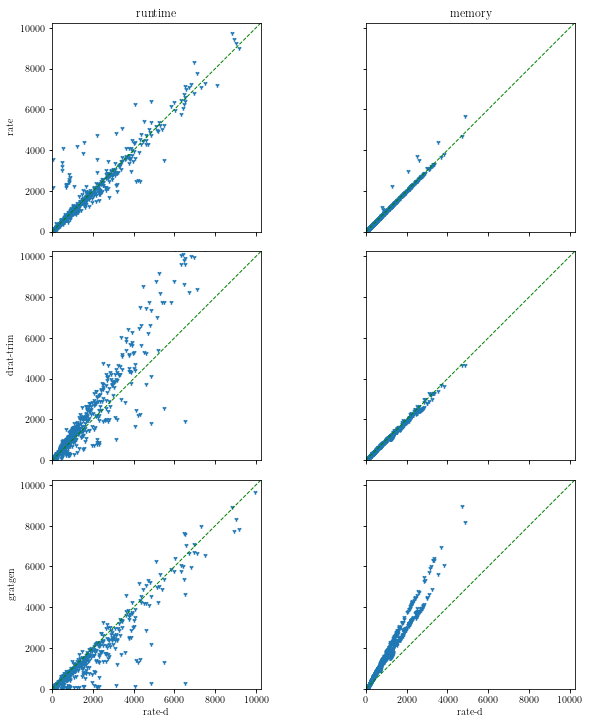

In [272]:
def mcrossplot(ax, df, x, y, **kwargs):
    # limit = max(df[x].max(), df[y].max()) * 1.02
    if 'time' in x:
        limit = 20000
    else:
        limit = 24 * (2**10) # 24 GB in MB
        limit = 10 * (2**10) # 10 GB
        assert max(df[x].max(), df[y].max()) < limit
    df.plot(x, y, kind='scatter', marker='1', xlim=(0, limit), ylim=(0, limit), ax=ax, **kwargs)
    ax.plot((0, limit), (0, limit), color='green', linestyle='dashed', linewidth=1)

fig, axes = plt.subplots(3, 2, figsize=(10, 10), subplot_kw={'aspect': 'equal'}, sharex='all', sharey='all')
# plt.subplots_adjust(left=.125, bottom=.1, right=.9, top=.9, wspace=.3, hspace=.2)
# plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
# plt.subplots_adjust(hspace=.0)
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]
ax5, ax6 = axes[2]

mcrossplot(ax1, vf, 'rate-d-time', 'rate-time')
mcrossplot(ax2, vf, 'rate-d-space', 'rate-space')
mcrossplot(ax3, vf, 'rate-d-time', 'drat-trim-time')
mcrossplot(ax4, vf, 'rate-d-space', 'drat-trim-space')
mcrossplot(ax5, vf, 'rate-d-time', 'gratgen-time')
mcrossplot(ax6, vf, 'rate-d-space', 'gratgen-space')
plt.tight_layout()

ax1.set_title('runtime')
ax2.set_title('memory')
ax1.set_ylabel('rate')
ax3.set_ylabel('drat-trim')
ax5.set_ylabel('gratgen')
ax5.set_xlabel('rate-d')
ax6.set_xlabel('rate-d')
persist('cross')


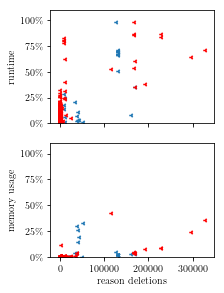

In [284]:
def mcorrelation(ax, df, x, y, percent=False, **kwargs):
    vf[vf['rate-reason-deletions-shrinking-trail'] != 0].plot(x, y, ax=ax, kind='scatter', marker='3', **kwargs);
    vf[vf['rate-reason-deletions-shrinking-trail'] == 0].plot(x, y, ax=ax, kind='scatter', marker='3', color='red', **kwargs);
    # limit = df[x].max()
    # ax.plot((0, limit), (0, 0), color='green', linestyle='dashed', linewidth=1)
    if percent:
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y:.0%}'.replace('%', r'\%')))
        set_labels(ax, x, y)

pclim = (0, 1)
assert df['time-delta-percent-rate-rate-d'].max() < pclim[1]
assert df['space-delta-percent-rate-rate-d'].max() < pclim[1]
fig, axes = plt.subplots(2, 1, sharex='all', figsize=(3, 4))
plt.tight_layout()
ax1 = axes[0]
ax2 = axes[1]
ax1.set_ylim(pclim)
ax2.set_ylim(pclim)
# ax1 = plt.subplot(2, 1, 1, ylim=pclim)
# ax2 = plt.subplot(2, 1, 2, ylim=pclim, sharex=ax1)
mcorrelation(ax1, vf, 'rate-reason-deletions', 'time-delta-percent-rate-rate-d', percent=True)
mcorrelation(ax2, vf, 'rate-reason-deletions', 'space-delta-percent-rate-rate-d', percent=True)
persist('correlation-reason-deletions')

# Poster

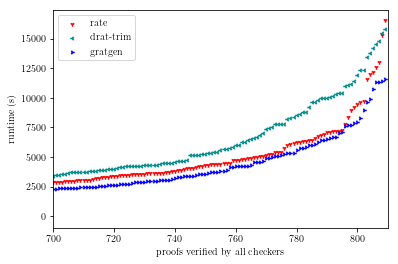

In [285]:
compare(plt.subplot(), vf, 'time', xlim=(easy_problems, len(vf)), cs=('rate', 'drat-trim', 'gratgen')); persist('cactus-time3')

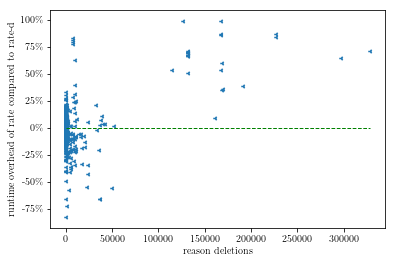

In [104]:
c1, c2 = 'rate', 'rate-d'
LABELS[f'time-delta-percent-{c1}-{c2}'] = f'runtime overhead of {c1} compared to {c2}'
correlation(plt.subplot(), vf, 'rate-reason-deletions', 'time-delta-percent-rate-rate-d', percent=True); persist('correlation-reason-deletions-time-delta-percent')